## Neuron Simulations

Neurons have complex biophysical properties that can be simulated using python.
In the following I will present progressively more complex models of neuron simulation.
The project will be concluded by an algorithm that translates auditory information into electrical signals that activate neurons in the cochlea (inner ear). Its a rudimentary approach to a cochela implant algorithm

## The Leaky Integrate and Fire Model

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


def membrane_voltage(vm, i_stim, cm, g_leak, params):
    r = 1 / g_leak
    tau = cm * r

    for index in range(len(params["time"]) - 1):
        if vm[index] < params["v_thr"]:
            vm[index + 1] = (((-vm[index] + params["v_rest"]) / tau) + (i_stim[index] / cm)) * \
                            params["step_size"] + vm[index]
        elif vm[index] == params["v_spike"]:
            vm[index + 1] = params["v_rest"]
        elif vm[index] > params["v_thr"]:
            vm[index + 1] = params["v_spike"]

    return vm


# Define the params dictionary
params = {
    "v_rest": -70e-3,
    "v_thr": -30e-3,
    "v_spike": 20e-3,
    "step_size": 30e-6,
    "cm": 1e-6,
}

params["time"] = np.arange(0, 0.1, params["step_size"])

# Create an interactive plot using widgets.interact
i_stim_slider = widgets.FloatSlider(
    value=10e-6,
    min=3, 
    max=10, 
    step=2, 
    description='I_stim [uA]',
    continuous_update=False
)

def interactive_plot(i_stim_val):
    vm = np.zeros(len(params["time"]))
    vm[0] = params["v_rest"]

    i_stim = np.zeros(len(params["time"]))
    i_stim[:4999] = i_stim_val/1_000_000 # Stimulation current in uA

    g_leak = 100e-6

    vm = membrane_voltage(vm, i_stim, params["cm"], g_leak, params)

    plt.figure(figsize=(16, 6))
    plt.plot(params["time"], vm)
    plt.axhline(y=-0.03, linestyle="dashed", color="red", label='Threshhold potential (-30mV)')
    plt.xlabel("Time (s)")
    plt.ylabel("Membrane Voltage (V)")
    plt.title("Leaky Integrated Fire Model")
    plt.grid()
    plt.legend()

    plt.show()

widgets.interactive(interactive_plot, i_stim_val=i_stim_slider)

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='I_stim [$\\mu$A]', max=10.0…

## Hodgkin-Huxley-Model

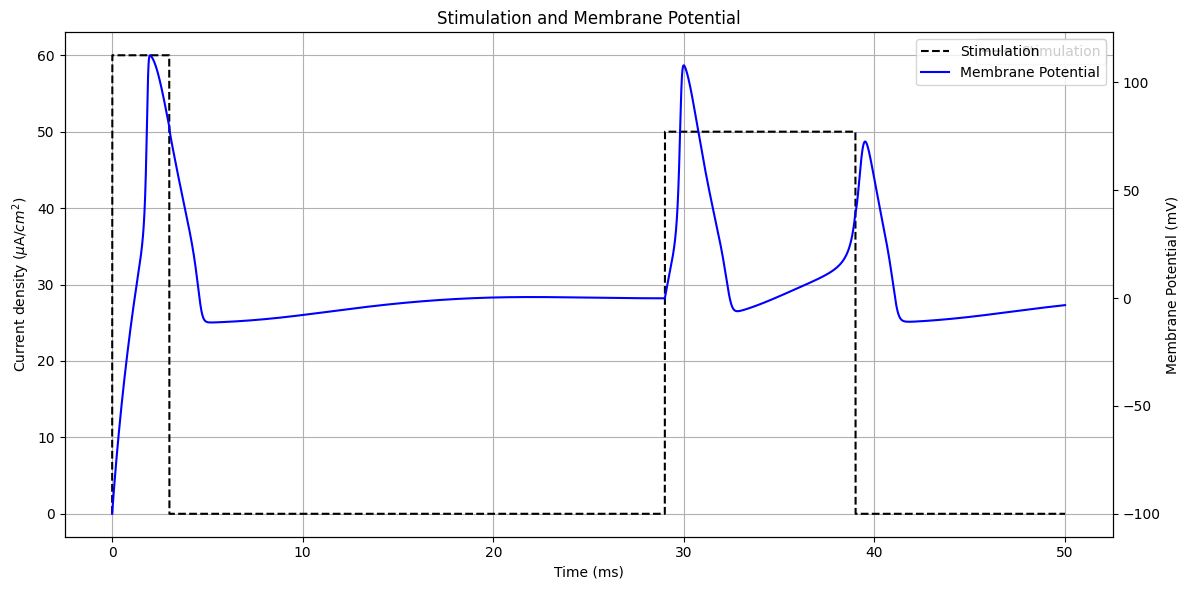

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 50.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))


# Input stimulus
def Id(t):
    if 0.0 < t < 3.0:
        return 60.0
    elif 29.0 < t < 39.0:
        return 50.0
    return 0.0


# Compute derivatives
def compute_derivatives(y, t0):
    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    dy = [
        (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy


# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

# Input stimulus
Idv = np.vectorize(Id)(T)

# Plotting
fig, axes1 = plt.subplots(figsize=(12, 6))

# Plot the stimulus on the first axes (left y-axis)
axes1.plot(T, Idv, linestyle="dashed", color="black", label='Stimulation')
axes1.set_xlabel('Time (ms)')
axes1.set_ylabel(r'Current density ($\mu$A/$cm^2$)')
axes1.set_title('Stimulation and Membrane Potential')
axes1.grid()
axes1.legend()

# Create a twin axes for the right y-axis
axes2 = axes1.twinx()

# Plot the Membrane potential on the second axes (right y-axis)
axes2.plot(T, Vm_values, color='blue', label='Membrane Potential')
axes2.set_ylabel('Membrane Potential (mV)')

# Combine the legends from both axes
lines, labels = axes1.get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()
axes2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

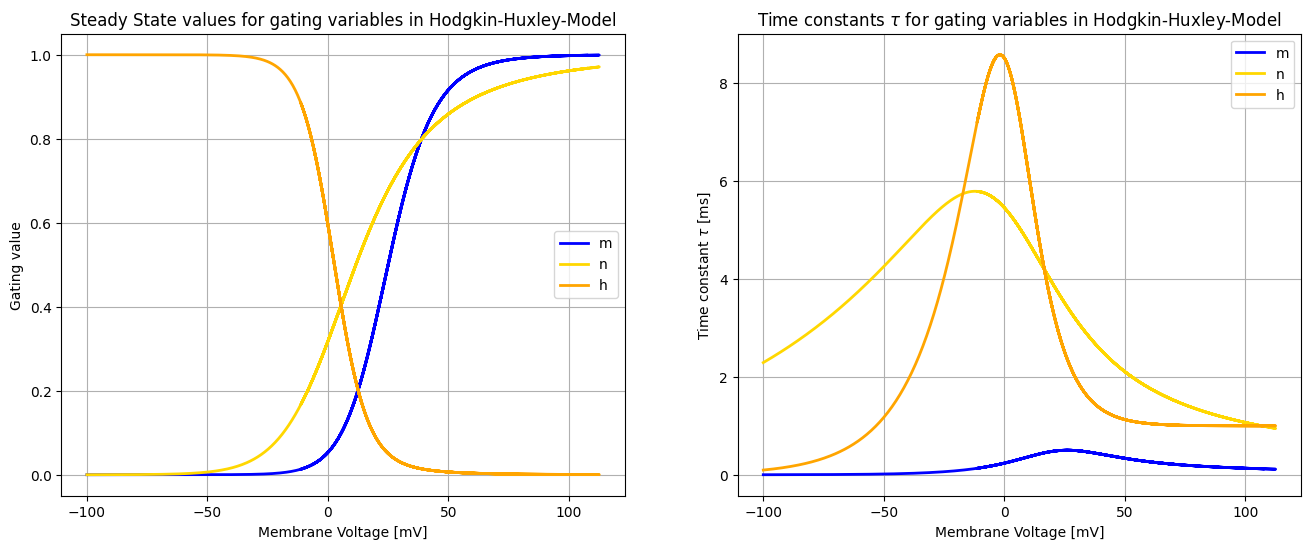

In [59]:
# Initial conditions
Y0 = [-100, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

fig, ax = plt.subplots(1,2, figsize=(16, 6))
Vm_values = Vy[:, 0]

ax[0].plot(Vm_values, m_inf(Vm_values), color="blue", linewidth=2, label="m")
ax[0].plot(Vm_values, n_inf(Vy[:, 0]), color="gold", linewidth=2, label="n")
ax[0].plot(Vy[:, 0], h_inf(Vy[:, 0]), color="orange", linewidth=2, label="h")
ax[0].set_xlabel("Membrane Voltage [mV]")
ax[0].set_ylabel("Gating value")
ax[0].set_title("Steady State values for gating variables in Hodgkin-Huxley-Model")
ax[0].legend()
ax[0].grid()


m_time_const = (1/(alpha_m(Vm_values)+beta_m(Vm_values)))
n_time_const = (1/(alpha_n(Vm_values)+beta_n(Vm_values)))
h_time_const = (1/(alpha_h(Vm_values)+beta_h(Vm_values)))

ax[1].plot(Vm_values, m_time_const, color="blue", linewidth=2, label="m")
ax[1].plot(Vm_values, n_time_const, color="gold", linewidth=2, label="n")
ax[1].plot(Vm_values, h_time_const, color="orange", linewidth=2, label="h")

ax[1].set_xlabel("Membrane Voltage [mV]")
ax[1].set_ylabel(r"Time constant $\tau$ [ms]")
ax[1].set_title(r"Time constants $\tau$ for gating variables in Hodgkin-Huxley-Model")
ax[1].legend()
ax[1].grid()


plt.show()
